In [15]:
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_lightning import seed_everything
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import random
import os
from pathlib import Path
import shutil
import gzip
import requests
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
%matplotlib inline

# set seed 
def set_seed(seed = int):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    seed_everything(seed)
    return random_state
seed_number = 42
seed = set_seed(seed_number)

Global seed set to 42


# load data

In [16]:
train = pd.read_feather('../data/train_preprocessed.feather').sample(99999).reset_index(drop=True)
test = pd.read_feather('../data/test_preprocessed.feather')
train.head()

,chid_shop_tag_37_norm_count,chid_shop_tag_other_norm_count,chid_shop_tag_45_norm_count,chid_shop_tag_48_norm_count,card_4_txn_cnt,overseas_online_cnt,chid_shop_tag_36_norm_count,chid_shop_tag_2_norm_count,chid_shop_tag_15_norm_count,chid_shop_tag_12_norm_count,...,chid_shop_tag_9_norm_count,chid_shop_tag_17_norm_count,chid_shop_tag_41_norm_count,chid_shop_tag_20_norm_count,chid_shop_tag_8_norm_count,chid_shop_tag_32_norm_count,chid_shop_tag_40_norm_count,chid_shop_tag_3_norm_count,index,shop_tag
0,0.085714,0.057143,0.0,0.028571,0.0,0.0,0.000000,0.085714,0.057143,0.028571,...,0.0,0.0,0.0,0.0,0.0,0.057143,0.000000,0.000000,6582978,2
1,0.142857,0.000000,0.0,0.142857,0.0,0.0,0.000000,0.142857,0.428571,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,20740238,37
2,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,23388815,32
3,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.222222,0.000000,0.222222,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,22042470,36
4,0.000000,0.086957,0.0,0.000000,0.0,5.0,0.130435,0.043478,0.130435,0.130435,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.043478,0.086957,30085386,13


In [17]:
test.head()

,chid_shop_tag_37_norm_count,chid_shop_tag_other_norm_count,chid_shop_tag_45_norm_count,chid_shop_tag_48_norm_count,card_4_txn_cnt,overseas_online_cnt,chid_shop_tag_36_norm_count,chid_shop_tag_2_norm_count,chid_shop_tag_15_norm_count,chid_shop_tag_12_norm_count,...,chid_shop_tag_33_norm_count,chid_shop_tag_9_norm_count,chid_shop_tag_17_norm_count,chid_shop_tag_41_norm_count,chid_shop_tag_20_norm_count,chid_shop_tag_8_norm_count,chid_shop_tag_32_norm_count,chid_shop_tag_40_norm_count,chid_shop_tag_3_norm_count,index
0,0.2500,0.25,0.2500,0.0000,3.0,0.0,0.00,0.2500,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,0
1,0.1000,0.10,0.1000,0.1000,0.0,0.0,0.05,0.0000,0.1000,0.0,...,0.0,0.0,0.0500,0.05,0.0,0.0,0.0,0.0,0.0,1
2,0.2000,0.20,0.0000,0.2000,0.0,0.0,0.20,0.0000,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,2
3,0.0625,0.00,0.1875,0.0625,0.0,0.0,0.00,0.0625,0.0625,0.0,...,0.0,0.0,0.0625,0.00,0.0,0.0,0.0,0.0,0.0,3
4,0.2500,0.00,0.0000,0.0000,1.0,0.0,0.00,0.5000,0.0000,0.0,...,0.0,0.0,0.0000,0.00,0.0,0.0,0.0,0.0,0.0,4


# Define categorical features for categorical embeddings

In [18]:
unused_feat = ['index','shop_tag']
target = 'shop_tag'
categorical_columns = ['masts','educd','trdtp','naty','poscd','cuorg','gender_code','age','primary_card']
features = [ col for col in train.columns if col not in unused_feat+[target]] 
cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
cat_idxs

[]

# Network parameters

In [19]:
exec(requests.get('https://raw.githubusercontent.com/facebookresearch/madgrad/main/madgrad/madgrad.py').text)
clf = TabNetClassifier(
    cat_idxs = cat_idxs,
    cat_dims = cat_dims,
    cat_emb_dim = 1,
    optimizer_fn=MADGRAD,
    optimizer_params=dict(lr=2e-2))

Device used : cuda


# train val test split

In [20]:
num_Fold = 0
Folds = {}
kf = KFold(n_splits = 5 ,random_state=seed)
for i,train_val_index in enumerate(kf.split(train.index)):
  Folds[i] = train_val_index
train_index ,val_index = Folds[num_Fold]
val = train.loc[val_index,features+[target]]
train = train.loc[train_index,features+[target]]

X_train = train[features].values
y_train = train[target].values

X_valid = val[features].values
y_valid = val[target].values

X_test = test[features].values

C:\Users\ricky\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


# Train

In [21]:
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=10,
)

epoch 0  | loss: 3.60844 | train_accuracy: 0.18093 | valid_accuracy: 0.1832  |  0:00:06s
epoch 1  | loss: 2.73538 | train_accuracy: 0.26922 | valid_accuracy: 0.27065 |  0:00:13s
epoch 2  | loss: 2.55553 | train_accuracy: 0.30509 | valid_accuracy: 0.31    |  0:00:20s
epoch 3  | loss: 2.45049 | train_accuracy: 0.34518 | valid_accuracy: 0.34535 |  0:00:26s
epoch 4  | loss: 2.35591 | train_accuracy: 0.37003 | valid_accuracy: 0.3694  |  0:00:33s
epoch 5  | loss: 2.28698 | train_accuracy: 0.3746  | valid_accuracy: 0.3787  |  0:00:39s
epoch 6  | loss: 2.23417 | train_accuracy: 0.38987 | valid_accuracy: 0.3865  |  0:00:45s
epoch 7  | loss: 2.18925 | train_accuracy: 0.3956  | valid_accuracy: 0.39315 |  0:00:51s
epoch 8  | loss: 2.14931 | train_accuracy: 0.40074 | valid_accuracy: 0.3969  |  0:00:57s
epoch 9  | loss: 2.11817 | train_accuracy: 0.41254 | valid_accuracy: 0.41275 |  0:01:03s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_accuracy = 0.41275
Best w

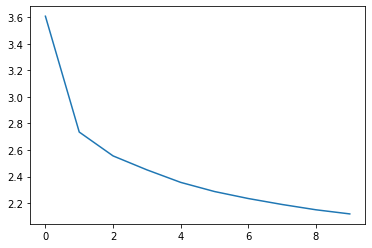

In [22]:
# plot losses
plt.plot(clf.history['loss'])

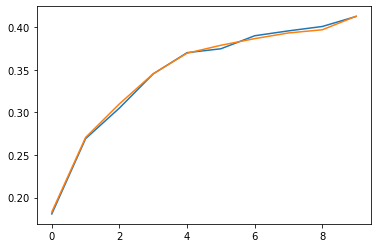

In [23]:
# plot accuracy
plt.plot(clf.history['train_accuracy'])
plt.plot(clf.history['valid_accuracy'])

# Predictions

In [24]:
preds_mapper = { idx : class_name for idx, class_name in enumerate(clf.classes_)}
preds = clf.predict_proba(X_valid)
y_pred = np.vectorize(preds_mapper.get)(np.argmax(preds, axis=1))
valid_acc = accuracy_score(y_pred=y_pred, y_true=y_valid)
print(f"BEST VALID SCORE FOR : {clf.best_cost}")
print(f"FINAL VALID SCORE FOR : {valid_acc}")

BEST VALID SCORE FOR : 0.41275
FINAL VALID SCORE FOR : 0.41275


# Save oof train and oof test

In [25]:
oof_train = clf.predict_proba(X_valid)
oof_train.shape

(20000, 48)

In [26]:
oof_test = clf.predict_proba(X_test)
oof_test.shape

(500000, 48)

In [27]:
print(num_Fold)
print(seed_number)

0
42


In [28]:
oof_train = pd.DataFrame(oof_train,columns=[ str(i) for i in range(oof_train.shape[1])])
oof_test = pd.DataFrame(oof_test,columns=[ str(i) for i in range(oof_test.shape[1])])
oof_train.to_feather(f'../data/submit/oof_train_fold_{num_Fold}_seed_{seed_number}')
oof_test.to_feather(f'../data/submit/oof_test_fold_{num_Fold}_seed_{seed_number}')
print('DONE!')

DONE!
